In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit?
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'medium',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium'}
# pylab.rcParams.update(params)

# #line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5

import torch
from torch.nn.functional import binary_cross_entropy_with_logits
import matplotlib.pyplot as plt

from monotonenorm import direct_norm, SigmaNet, GroupSort


monotonic = True
LIP = 1  # lipschitz constant of the model
EPOCHS = 500

Object `curve_fit` not found.


2023-01-19 06:45:03.873935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_training_data(dir_path):
    
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v8.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v8.root")
    
    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()
    
    pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()
    deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()
    selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4)
    
    pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()
    deltaR_bkg = bkg['ntuplePupSingle']['tree']['gendr1'].array()
    selection_bkg = pt_bkg > 20
    
    #Maybe better to use 2.4 for eta
    
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.asarray(sig_input[selection_sig])
    y_sig = np.full(X_sig.shape[0], 1)
    
    X_bkg = np.asarray(bkg_input[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0)
    
    X = np.concatenate([X_sig, X_bkg])
    y = np.concatenate([y_sig, y_bkg])
    
    index = np.arange(X.shape[0])
    
    X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, index, test_size=0.2, random_state=42)
    
    return torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test), torch.from_numpy(index_train), torch.from_numpy(index_test)

In [3]:
X_train, X_test, y_train, y_test, index_train, index_test = create_training_data("../ntuples/Jan_17_2023")

In [4]:
contraint_index_part = [1] + [0]*7
contraint_index = contraint_index_part*10

In [5]:
def get_model(monotonic):
    def lipschitz_norm(module):
          return direct_norm(
              module,  # the layer to constrain
              "inf",  # |W|_1 constraint type
              max_norm=LIP ** (1 / 3),  # norm of the layer (LIP ** (1/nlayers))
              )

    model = torch.nn.Sequential(
      lipschitz_norm(torch.nn.Linear(80, 25)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(25, 10)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(10, 10)),
      GroupSort(5),
      lipschitz_norm(torch.nn.Linear(10, 1)),
    )

    if monotonic:
        model = SigmaNet(
          model,
          sigma=LIP,
          monotone_constraints=contraint_index,
          # 0: don't constrain feature monotonicity,
          # 1: monotonically increasing,
          # -1: monotonically decreasing
          # for each feature individually
        )
        
    return model

In [6]:
model = get_model(monotonic)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [7]:
for i in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = binary_cross_entropy_with_logits(y_pred, y_train.view(-1, 1).float())
    loss.backward()
    optimizer.step()

In [8]:
y_pred = model(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred.detach().numpy())

auc_score = round(auc(fpr, tpr),2)

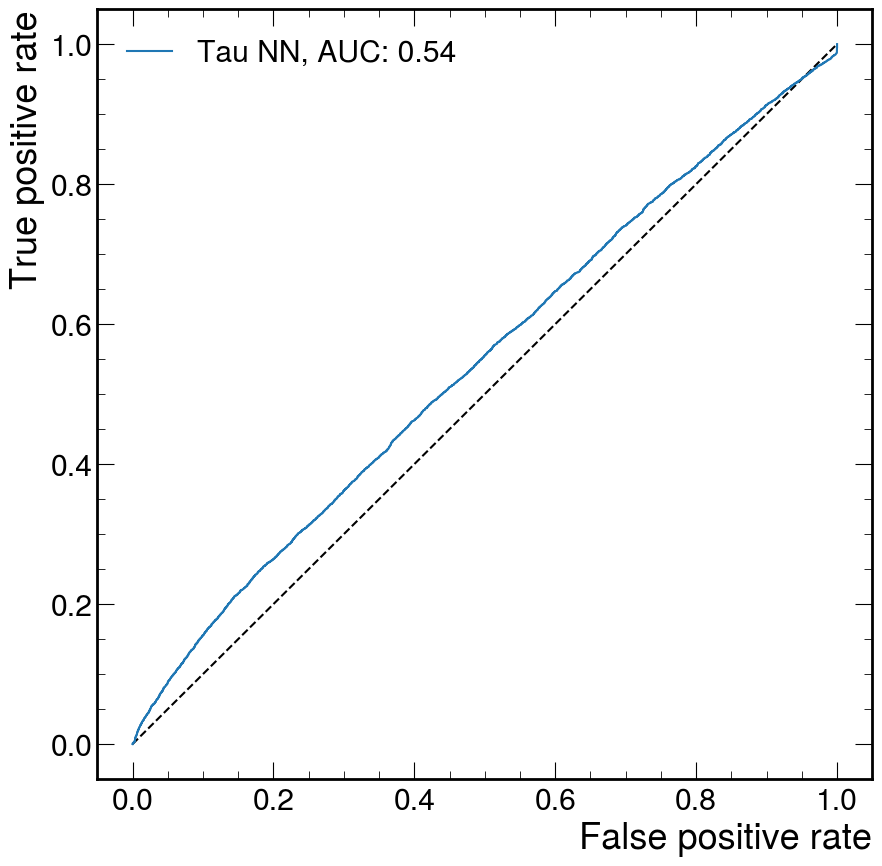

In [9]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label = 'Tau NN, AUC: {}'.format(auc_score))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

## Make efficiency plot

In [23]:
#Load the test indices
test_index = np.load("../ntuples/Jan_17_2023/index_test.npy")

sig = uproot4.open("../ntuples/Jan_17_2023/test_sig_v8.root")
tau_pt = sig['ntuplePupSingle']['tree']['pt'].array()[test_index]

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index]

pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index]
selection_sig = (pt_sig > 20) &(abs(deltaR_sig) < 0.4)

#Selected out the tau pt with the basic cuts first
tau_pt_cut = tau_pt[selection_sig]

In [24]:
X_sig = torch.from_numpy(np.asarray(sig_input[selection_sig]))
y_sig = model(X_sig)

In [25]:
nn_cut = y_sig.detach().numpy().flatten() > 0.5

In [26]:
tau_pt_nn = np.asarray(tau_pt_cut)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[test_index][selection_sig])
tau_pt_old_nn = tau_pt_cut[old_tau_select == 1]

#Fill two plots and divide the two.
pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
pT_axis = hist.axis.Variable(pT_egdes, name = r"$\tau_h$ $p_T$")

hist_all_tau = Hist(pT_axis)
hist_selected_tau = Hist(pT_axis)
hist_selected_old_tau = Hist(pT_axis)

hist_all_tau.fill(tau_pt_cut)
hist_selected_tau.fill(tau_pt_nn)
hist_selected_old_tau.fill(tau_pt_old_nn)

Hist(Variable([0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100, 125, 150], name='$\\tau_h$ $p_T$'), storage=Double()) # Sum: 6174.0 (6350.0 with flow)

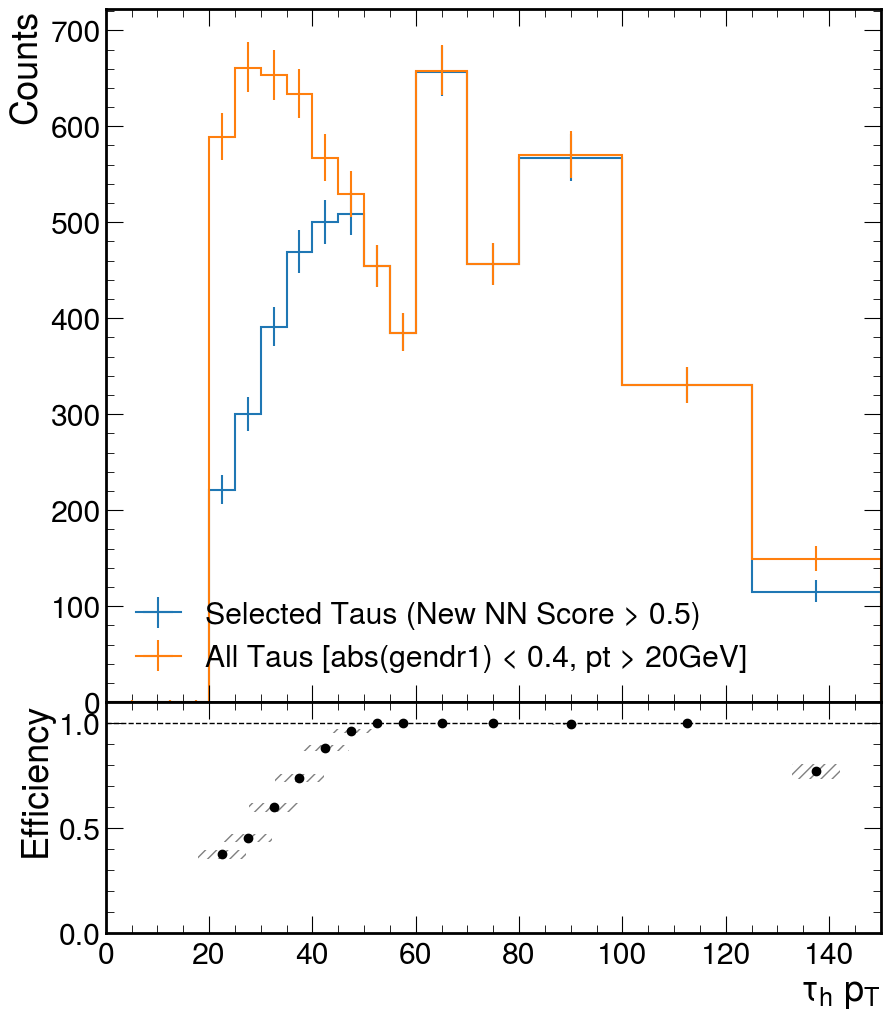

In [27]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (New NN Score > 0.5)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

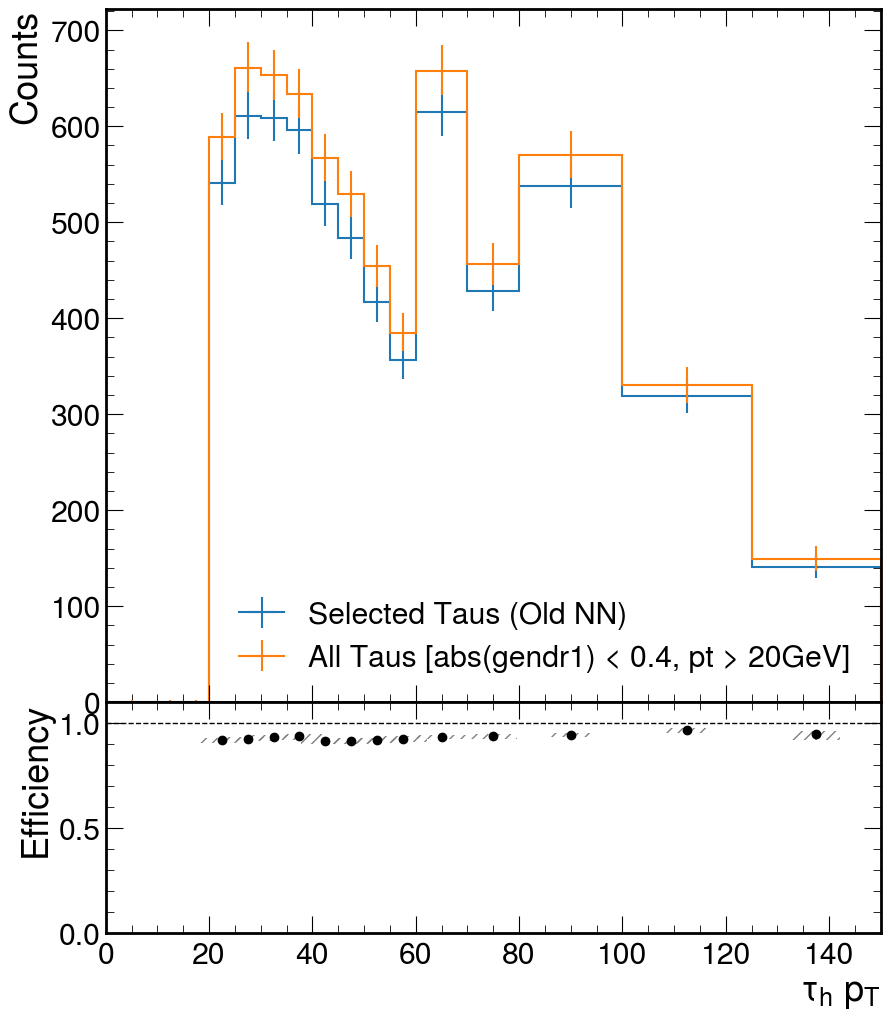

In [28]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Old NN)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

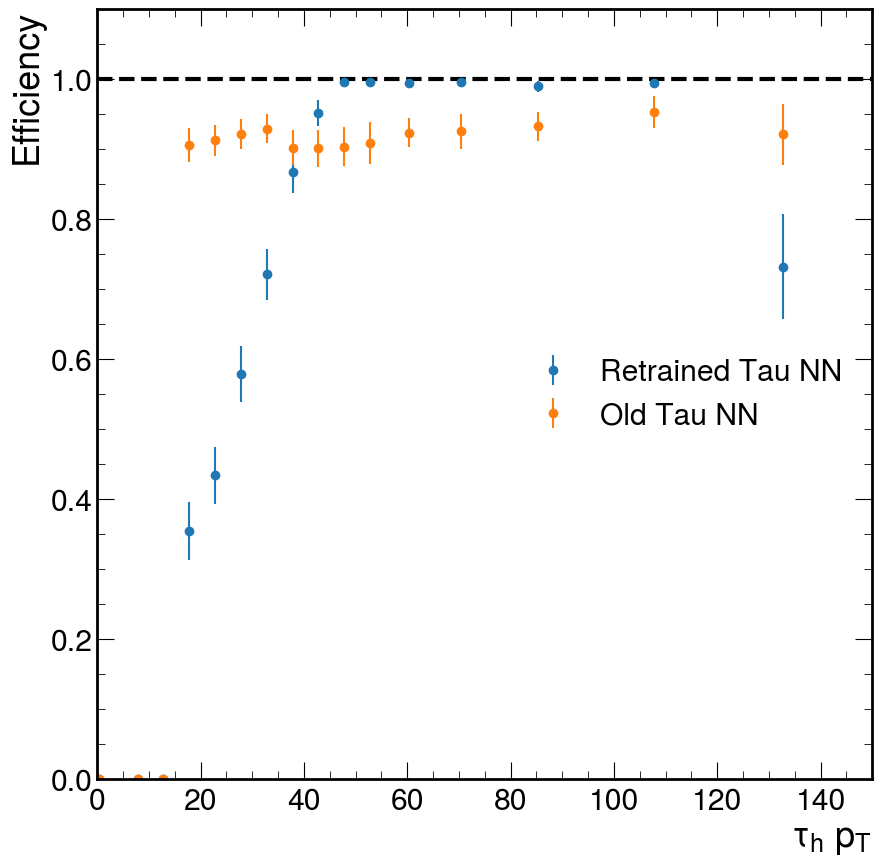

In [29]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([0,150])
plt.xlabel(r"$\tau_h$ $p_T$")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()

In [30]:
tau_eta = sig['ntuplePupSingle']['tree']['eta'].array()[test_index]
tau_eta_cut = tau_eta[selection_sig]
tau_eta_nn = np.asarray(tau_eta_cut)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[test_index][selection_sig])
tau_eta_old_nn = tau_eta_cut[old_tau_select == 1]

#Fill two plots and divide the two.
eta_egdes = [-2.5,-2.3,-2.0,-1.8,-1.6,-1.4,-1.0,-0.6,-0.2,0.2,0.6,1.0,1.4,1.6,1.8,2.0,2.3,2.5]
eta_axis = hist.axis.Variable(eta_egdes, name = r"$\tau_h$ $\eta$")

hist_all_tau = Hist(eta_axis)
hist_selected_tau = Hist(eta_axis)
hist_selected_old_tau = Hist(eta_axis)

hist_all_tau.fill(tau_eta_cut)
hist_selected_tau.fill(tau_eta_nn)
hist_selected_old_tau.fill(tau_eta_old_nn)

Hist(Variable([-2.5, -2.3, -2, -1.8, -1.6, -1.4, -1, -0.6, -0.2, 0.2, 0.6, 1, 1.4, 1.6, 1.8, 2, 2.3, 2.5], name='$\\tau_h$ $\\eta$'), storage=Double()) # Sum: 6350.0

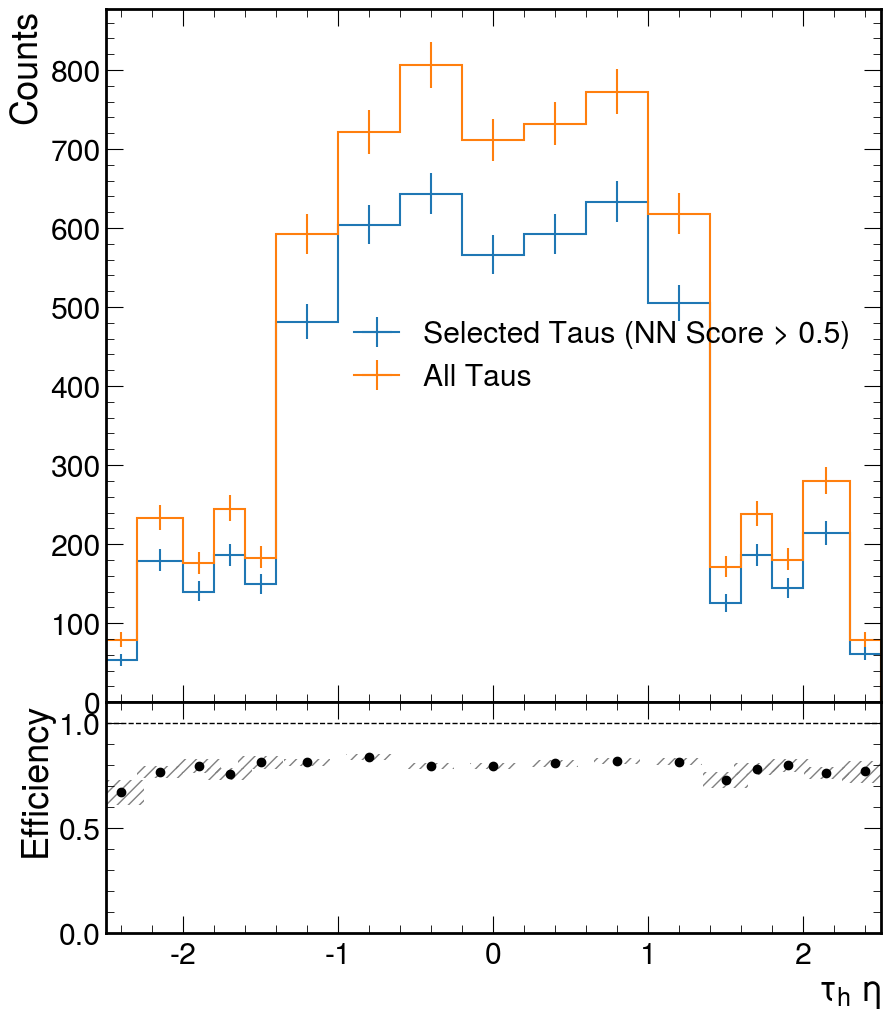

In [31]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (NN Score > 0.5)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

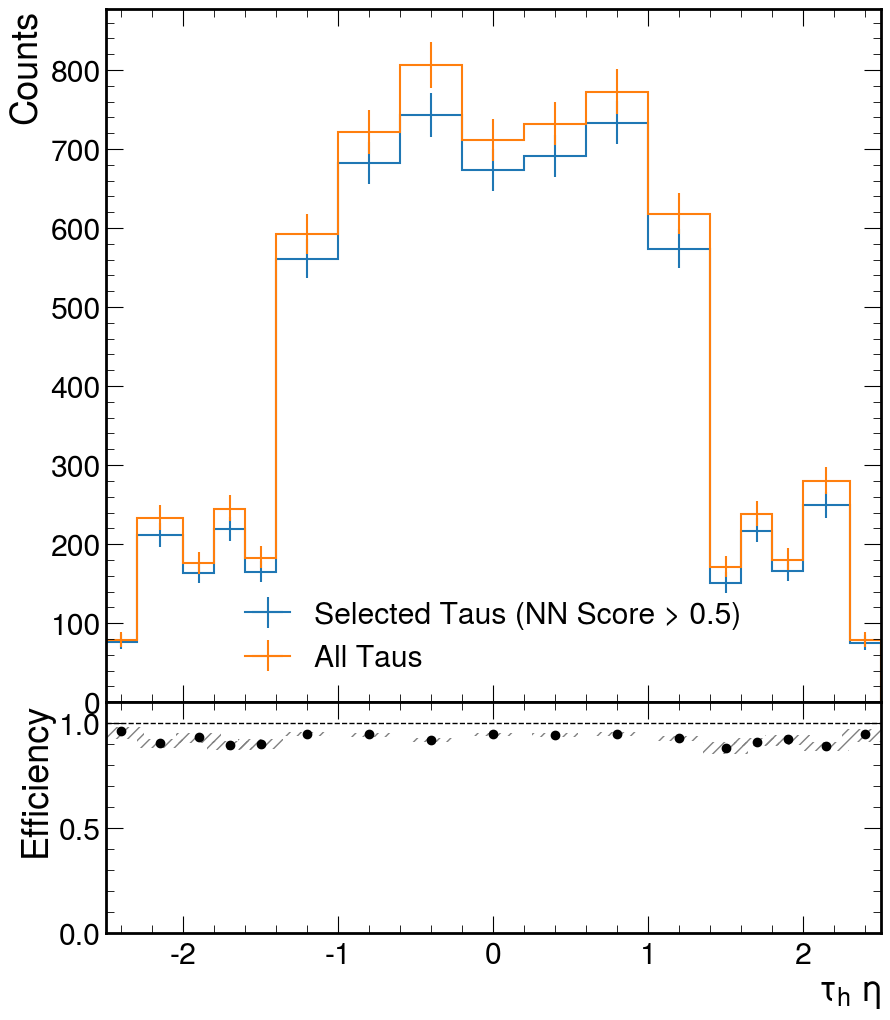

In [32]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (NN Score > 0.5)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

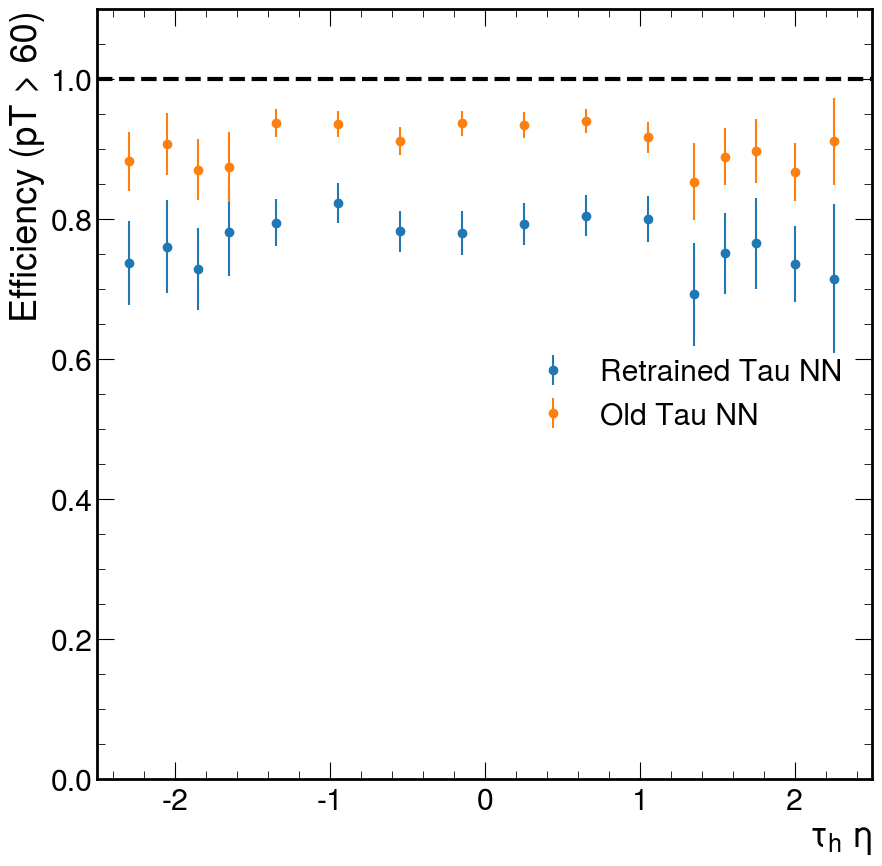

In [33]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, -2.5, 2.5, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([-2.5,2.5])
plt.xlabel(r"$\tau_h$ $\eta$")
plt.ylabel("Efficiency (pT > 60)")
plt.legend(loc = 'center right')
plt.show()